# Selection of the rank of kernel conditional moment constraints
The rank of the kernel conditional moment constraints is the most important parameter of a kernel conditional moment constraints (KCMC) estimator. This is because a too low rank would give us too pessimistic a worst-case lower bound, while we would get an overly optimistic bound if the chosen rank is too high. 

For this purpose, use the reformulation of the KCMC estimator as an M-estimator. Once we have a M-estimation problem

\begin{equation*}
\hat\theta = \arg\min_{\theta\in\Theta} \hat {\mathbb{E}}_n \ell_\theta(Z),
\end{equation*}

we can apply any methods for model selection in statistics and machine learning. Here, in this notebook, we consider the following two approaches for selecting the rank of KCMC:
- Generalized information criterion
- Cross-validation

In [4]:
import torch
import confounding_robust_inference as cri


# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(250)

## Generalized Information Criterion (GIC)

GIC is an estimator of the population risk of the M-estimator ${\mathbb{E}}\ell_{\hat\theta}(Z)$, (instead of empirical risk $\hat{\mathbb{E}}_n\ell_{\hat\theta}(Z)$). It is a generalized version of better-known AIC (Akaike's information criterion) for maximum likelihood estimation, and its derivation depends on the asymptotic analysis of the estimator.

In [5]:
# Robust estimator of the policy value:
estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=1.5, D=4)
estimator.fit(Y, T, X, p_t, policy)
estimator.predict()

# We can also compute the theoretical robust policy value by Monte Carlo sampling with the true data distribution:
data.evaluate_policy(policy, n_mc=100000)

tensor(4.3882, dtype=torch.float64)

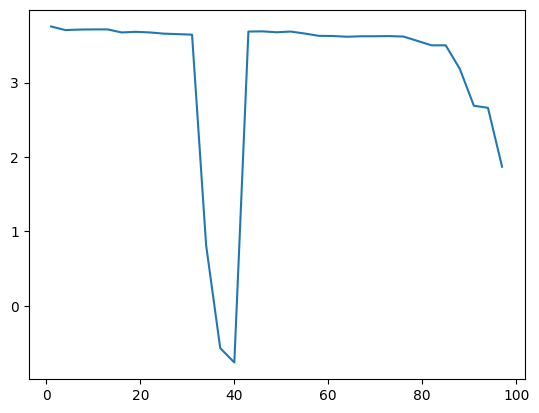

In [6]:
import warnings


def GIC(D):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(Y, T, X, p_t, policy)
        return est.predict_gic()


import matplotlib.pyplot as plt

plt.plot(range(1, 100, 3), [GIC(d) for d in range(1, 100, 3)])

## Cross-Validation